# Introduction to Computer Simulation using SimPy

**In this practical you will learn:**

* Random Sampling from parametric distributions in `numpy`
    * Controlling sampling using numpy random generators and seeds
* How to code a `simpy` environment and create basic process models
* How to model resources and simulate queues
* How to organise model distribution and input parameters using python classes
* How to collect results from a single run of the model

---

## Video playlist walk through of notebook and solving exercises

* [Notebook walkthrough](https://bit.ly/hpdm097_intro_simpy)

> If you follow the above walk-through it is recommended that you do so in sections.  You will learn the most if you attempt to write the code yourself.

---

## Imports

It is recommended that you use the provided environment `hds_stoch`.  Please use simpy v4.0.x and numpy v 1.18.x +

>If you are running this notebook in Google colab then `simpy` can be installed by:

```python
!pip install simpy
```

In [1]:
import simpy
simpy.__version__

'4.1.1'

In [2]:
import numpy as np
import pandas as pd
import itertools
import math
import matplotlib.pyplot as plt

In [3]:
np.__version__

'1.26.2'

## Random Sampling from Parametric Distributions in `numpy`

Before we progress to building `simpy` models we first need to explore how we can generate samples from well known statistical distributions in Python.  We will explore a range of statistical distributions in **input modelling**.  For now we will limit ourselves to some useful simple models.

In [4]:
def distribution_plot(samples, bins=100):
    '''
    helper function to visualise the distributions
    '''
    hist = np.histogram(samples, bins=np.arange(bins), density=True)
    plt.plot(hist[0]);
    plt.ylabel('p(x)');
    plt.xlabel('x');

### The `numpy.random` namespace

Python provides several libraries for random sampling.  To begin with we will work with `numpy.random`.  This has the advantage of a very simple interface.  It is also possible to control pseudo random number streams using a seed on its own or paired with a `numpy.random.Generator` object

### Simple and useful distributions

#### Exponential distribution

Useful for modelling the time between arrivals (Inter-Arrival Time; IAT). 

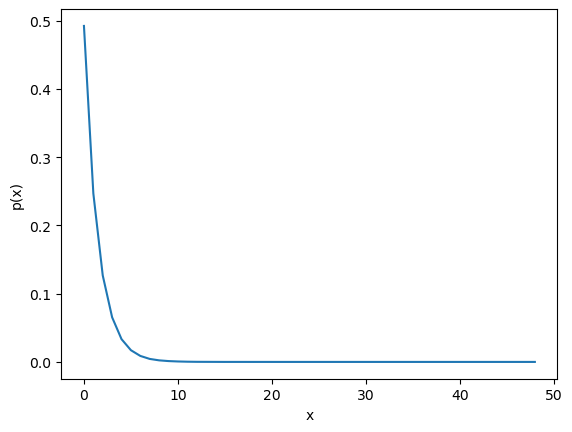

In [5]:
samples = np.random.exponential(scale=1.5, size=100000)
distribution_plot(samples, bins=50)

### Triangular distribution

Useful when not much is known about a distribution other than its likely range and the most common (mode) value.

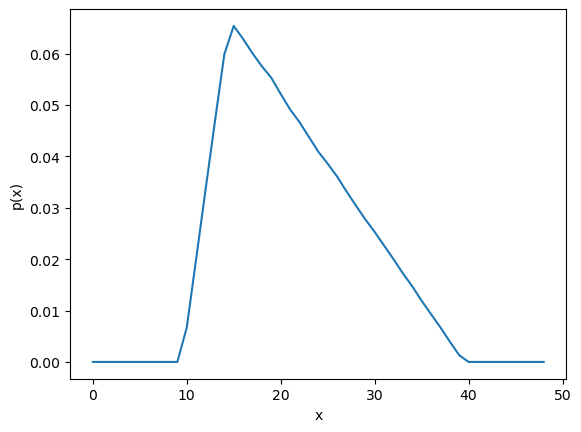

In [6]:
samples = np.random.triangular(left=10, mode=15, right=40, size=1000000)
distribution_plot(samples, bins=50)

#### Uniform distribution

Useful as an approximation when little is known, but a likely range of values

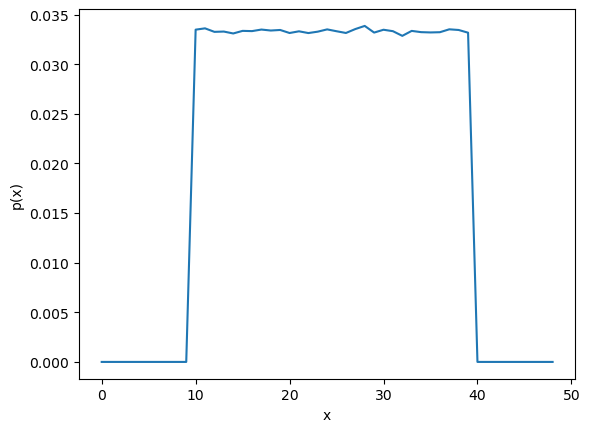

In [7]:
samples = np.random.uniform(low=10, high=40, size=1000000)
distribution_plot(samples, bins=50)

## Bernoulli distribution

Often in simulation models you need to sample a **1 or 0** or **True or False** value with 1 having a given probability $p$.  This for example might represent the probability that some process or another is followed.  

This can be achieved by using the Bernoulli distribution.  In NumPy we can sample from Bernoulli distribution in a slightly roundabout way.  We use a generalisation of the Bernoulli distribution called the Binomial.  If you set the parameter n = 1 this will generate a single uniform random number $U$ between 0 and 1.  If $U \leq p$ then it returns 1 else it returns 0.

In [8]:
np.random.binomial(n=1, p=0.4, size=10)

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 1])

### Controlling random sampling using `np.random.seed`

We are modelling stochastic systems **BUT** our models should be controllable.  That means we should be able to rerun models and get the same results.  In simulation we do this by controlling the pseudo random number streams.

> In `numpy` one way to do this is setting a random seed.

```python
SEED = 42
np.random.seed(seed=SEED)
```
Let's create a random variable that is exponentially distributed.  We will conduct two rounds of sampling. Each round will consist of two sample batches each containing 10 samples. In the first round, we will ignore the random seed.  In the second round we will set the random seed in between each the batches.


In [9]:
# round 1 => batch 1
np.random.exponential(scale=1.5, size=10)

array([1.11403041, 2.96647172, 1.22547144, 3.97552383, 1.23432875,
       0.74540125, 0.7178006 , 0.81222154, 1.06189289, 0.73456772])

In [10]:
# round 1 => batch 2
np.random.exponential(scale=1.5, size=10)

array([3.91239964e+00, 7.89649022e-01, 1.58751352e+00, 9.50047667e-01,
       4.03344229e-02, 2.32668493e-01, 1.37580080e-01, 5.01724764e-01,
       3.34678269e+00, 3.41461476e-03])

You should notice that the random samples are different.  In fact, each time you run this you will get a different result. Not let's repeat that experiment, but this time set a random seed before each batch.

In [11]:
# round 2 => batch 1
np.random.seed(seed=42)
np.random.exponential(scale=1.5, size=10)

array([0.70390213, 4.51518215, 1.97511854, 1.36941383, 0.25443731,
       0.25439444, 0.08975815, 3.0168463 , 1.37862323, 1.84687509])

In [12]:
# round 2 => batch 2
np.random.seed(seed=42)
np.random.exponential(scale=1.5, size=10)

array([0.70390213, 4.51518215, 1.97511854, 1.36941383, 0.25443731,
       0.25439444, 0.08975815, 3.0168463 , 1.37862323, 1.84687509])

This time we get the same results.  Random sampling is not as random as it appears!  Always remember that simulation model is not a random game against nature.  It is a computer experiment.  **Hence it is controllable.**

### **Exercise 1**: controlled sampling from the uniform distribution

**Task:**

* Repeat the example given above, but this time use the uniform distribution.
* Use the random seed 101.  
* Try a few different seeds to check your code.
    

In [13]:
# your code here

### Complications: controlling sampling from multiple distributions

Consider a project where you are modelling a simple two stage patient pathway. 

* In the first stage of the pathway patients undergo a procedure that requires on average a 3 day spell in hospital. 
* In the second stage the patient undergoes therapy at home.  On average a patient requires home therapy for 7 days.  
* A hospital is interested in what would happen to resource requirements if an intervention they have planned reduced demand on the service. 


Let's test out a simple model where we sample patients length of stay and home theory duration from two exponential distributions.  We will use a random number seed and run two scenarios.  In the first scenario we will test sample 5 patients.  In the second we will sample 2.

In [14]:
def print_patient_details(acute, home):
    '''
    Helper function.
    Formats length of stay in data frame
    '''
    df = pd.DataFrame(np.vstack([sample_acute, sample_home])).T
    df.columns = ['acute', 'home']
    return df.round(2)

In [15]:
# first test - 5 patients included.
N_PATIENTS = 5
np.random.seed(42)
sample_acute = np.random.exponential(scale=3, size=N_PATIENTS)
sample_home = np.random.exponential(scale=7, size=N_PATIENTS)

print_patient_details(sample_acute, sample_home)

,acute,home
0,1.41,1.19
1,9.03,0.42
2,3.95,14.08
3,2.74,6.43
4,0.51,8.62


In [16]:
# second test - 2 patients included.
N_PATIENTS = 2
np.random.seed(42)
sample_acute = np.random.exponential(scale=3, size=N_PATIENTS)
sample_home = np.random.exponential(scale=7, size=N_PATIENTS)
print_patient_details(sample_acute, sample_home)

,acute,home
0,1.41,9.22
1,9.03,6.39


When the number of patients is reduced from 5 to 2 we get different sample values for the home therapy durations.  This is problematic because if we are not careful we may attribute improvements or lack of improvements between designs simply due to sampling variation.  

We are going to look at multiple ways to carefully analyse our model.  But for now it is useful to understand that we get this result because both distributions are using the same single stream of pseudo random numbers.  One way to solve this problem is therefore to give each distribution its **own stream**.

> In python we can do this using `numpy.random.Generator`.  We create a generator using the `numpy.random.default_rng()` function.

In [17]:
# first retest - 5 patients included.
N_PATIENTS = 5

# create two random generator objects
rs_acute = np.random.default_rng(seed=42)
rs_home = np.random.default_rng(seed=101)

sample_acute = rs_acute.exponential(scale=3, size=N_PATIENTS)
sample_home = rs_home.exponential(scale=7, size=N_PATIENTS)

print_patient_details(sample_acute, sample_home)

,acute,home
0,7.21,28.63
1,7.01,4.05
2,7.15,6.69
3,0.84,7.23
4,0.26,4.48


In [18]:
# second retest - 2 patients included.
N_PATIENTS = 2

# create two random state objects
rs_acute = np.random.default_rng(seed=42)
rs_home = np.random.default_rng(seed=101)

sample_acute = rs_acute.exponential(scale=3, size=N_PATIENTS)
sample_home = rs_home.exponential(scale=7, size=N_PATIENTS)

print_patient_details(sample_acute, sample_home)

,acute,home
0,7.21,28.63
1,7.01,4.05


Our second retest with a smaller group of patients now has the same acute and home sample values as the larger group.  We have successfully eliminated a some noise in our experiment and can more safely make statements about differences.  

> In general, it is recommended that models make use of `np.random.default_rng(seed)` which returns a `np.random.Generator` over and above `np.random.seed(seed)`.  We will revisit this method later in the course and explore it in more detail.

### **Exercise 2**: controlled sampling from the uniform distribution using a Generator object

**Task:**

* Repeat exercise 1, but make this time control sampling using a `np.random.Generator` object.
* Use the random seed 101.  
* Try a few different seeds to check your code.

In [19]:
# your code here

### **Exercise 3**: add a third distribution to the treatment pathway example.

**Task:**

* Modify the code below to include a third random distribution and ensure that the same sample values are returned no matter how many patients are included.

In [20]:
# first retest - 5 patients included.
N_PATIENTS = 5

rs_acute = np.random.default_rng(seed=42)
rs_home = np.random.default_rng(seed=101)

sample_acute = rs_acute.exponential(scale=3, size=N_PATIENTS)
sample_home = rs_home.exponential(scale=7, size=N_PATIENTS)
#sample_gp = #your code here

print_patient_details(sample_acute, sample_home)

,acute,home
0,7.21,28.63
1,7.01,4.05
2,7.15,6.69
3,0.84,7.23
4,0.26,4.48


## Coding basic `simpy` models

In this course we will make use of a **free and open source** discrete-event simulation python package called `simpy`.  

> An advantage of `simpy` over commercial simulation packages is its simplicity and flexibility.  As it is part of python, it is often straightforward to use `simpy` to model complex logic and make use of the SciPy stack!  Initially, you will need to write a lot of code. But don't worry. During the course we will build a up our own library of reusable code that we can draw on (and build on) for future simulation projects.  As `simpy` is free and open it has a big advantage over commercial software for both research and health system use.  



### A first example: a hospital pharmacy

In this first example, let's assume (unrealistically) that prescriptions arrive **exactly** 5 minutes apart.  To build this model we need the following components:

#### **A simpy environment**

`simpy` has process based worldview.  These processes take place in an environment.  You can create a environment with the following line of code:

```python
env = simpy.Environment()
```

#### **simpy timeouts**

We can introduce **delays** or **activities** into a process.  For example these might be the duration of a stay on a ward, or the duration of a operation.  In this case we are going to introduce a delay between arrivals (inter-arrival time).  In `simpy` you control this with the following method:

```python
activity_duration = 20
env.timeout(activity_duration)
```

#### **generators**

The event process mechanism in `simpy` is implemented using python generators.  A basic generator function that yields a new arrival every 5 minutes looks like this:

```python
def prescription_arrival_generator(env):
    while True:
        yield env.timeout(5.0)
```

Notice that the generator takes the environment as a parameter.  It then internally calls the `env.timeout()` method in an infinite loop.

#### **running a `simpy` model**

Once we have coded the model logic and created an environment instance, there are two remaining instructions we need to code.

1. set the generator up as a simpy process

```python
env.process(prescription_arrival_generator(env))
```

2. run the environment for a user specified run length

```python
env.run(until=25)
```

The run method handle the infinite loop we set up in `prescription_arrival_generator`. The simulation model has an internal concept of time.  It will end execution when its internal clock reaches 25 time units.

**Now that we have covered the basic building blocks, let's code the actual model.**  It makes sense to create our model logic first.  The code below will generate arrivals every 5 minutes.  Note that the function takes an environment object as a parameter.

In [21]:
def prescription_arrival_generator(env):
    '''
    Prescriptions arrive with a fixed duration of
    5 minutes.
    
    Parameters:
    ------
    env: simpy.Environment
    '''
    while True:
        inter_arrival_time = 5.0
        yield env.timeout(inter_arrival_time)
        print(f'Prescription arrives at: {env.now}')

Now that we have our generator function we can setup the environment, process and call run.  We will create a `RUN_LENGTH` parameter that you can change to run the model for different time lengths.  What would happen if this was set to 50?

In [22]:
# model parameters
RUN_LENGTH = 25

env = simpy.Environment()
env.process(prescription_arrival_generator(env))
env.run(until=RUN_LENGTH)
print(f'end of run. simulation clock time = {env.now}')

Prescription arrives at: 5.0
Prescription arrives at: 10.0
Prescription arrives at: 15.0
Prescription arrives at: 20.0
end of run. simulation clock time = 25


### **Exercise 3**: modelling a poisson arrival process for prescriptions

**Task:**

* Update `prescription_arrival_generator()` so that inter-arrival times follow an exponential distribution with a mean of 5.0 minutes between arrivals.
* Use a run length of 25 minutes.

> **Bonus**: try this initially **without** setting a random seed.  Then update the method choosing an approach to control random sampling.


In [23]:
# your code goes here

In [24]:
# example answer
def prescription_arrival_generator(env, random_seed=None):
    '''
    Prescriptions arrive with a fixed duration of
    5 minutes.
    
    Parameters:
    ------
    env: simpy.Environment
    
    random_state: int, optional (default=None)
        if set then used as random seed to control sampling.
    '''
    rs_arrivals = np.random.default_rng(random_seed)
    
    while True:
        inter_arrival_time = rs_arrivals.exponential(5.0)
        yield env.timeout(inter_arrival_time)
        print(f'Prescription arrives at: {env.now}')

In [25]:
# model parameters
RUN_LENGTH = 25
SEED = 23

env = simpy.Environment()
env.process(prescription_arrival_generator(env, random_seed=SEED))
env.run(until=RUN_LENGTH)
print(f'end of run. simulation clock time = {env.now}')

Prescription arrives at: 0.7378989827010132
Prescription arrives at: 2.070573882608715
Prescription arrives at: 2.6194454067498
Prescription arrives at: 6.302664339481998
Prescription arrives at: 16.936017243415527
end of run. simulation clock time = 25


### Example 2: Calling for 111

Call operators in an 111 (urgent care) service receive calls at a rate of 100 per hour. Call length can be represented by a triangular distribution.  Calls last between 5 minutes and 15 minutes. Most calls last 7 minutes. There are 13 call operators.  Build a `simpy` model of the process.

#### **simpy resources**

To model the call centre we need to introduce a **resource**.  If a resource is not available then a process will pause.  We create a resource as follows:

```python
operators = simpy.Resource(env, capacity=20)
```

When we want to request a resource in our process we create a with block as follows:

```python
with operators.request() as req:
    yield req
```

This tells simpy that your process needs an operator resource to progress.  The code will pause until a resource is yielded. This gives us our queuing effect.  If a resource is not available immediately then the process will wait until one becomes available.  We will practice this alot in the course so do not worry if this does not make sense immediately.

#### **using classes to represent a process**

The first thing we will do in our modelling task is create a `Patient` class.  (Note that you could also use simpy exclusively with functions.  However, we will prefer classes as this helps with thinking about design and results in cleaner code in complex models) This represents the service process that each calling patient experiences.  Remember we declare a class in python like so: We will do this step by step.

```python
class Patient:
```

We will then create a constructor method and pass in a unique `identifier`, a `simpy.Environment`, and the `simpy.Resource` that represents the operators.  

```python
    def __init__(self, identifier, env, operators):
        self.identifier = identifier
        self.env = env
        self.operators = operators
```

We can then create instances of a `Patient` as follows:

```python
identifier = 1
new_caller = Patient(identifier, env, operators)
```

Lastly, we need a method that simulates the service process.  A patient caller requests an operator, waits until one is available, and then talks to the operators.  The call duration follows a triangular distribution. We will `print` details of events as the process executes.  This will include, the time a call is answered, the time a call ends (and the duration of the call).  For now we won't worry about controlling the sampling.

```python
    def service(self):
        #record the time that call entered the queue
        start_wait = env.now

        #request an operator 
        with self.operators.request() as req:
            yield req
            
            #record the waiting time for call to be answered
            self.waiting_time = self.env.now - start_wait
            print(f'operator answered call {self.identifier} at {self.env.now:.3f}')
            
            #sample call duration.
            call_duration = np.random.triangular(left=0.01, mode=0.12, right=0.16)
            yield self.env.timeout(call_duration)
            
            print(f'call {self.identifier} ended {self.env.now:.3f}; ' \
                  + f'waiting time was {self.waiting_time:.3f}')

```

**The code for the full patient class is below:**

In [26]:
class Patient:
    '''
    Encapsulates the process a patient caller undergoes when they dial 111
    and speaks to an operator who triages their call.
    '''
    def __init__(self, identifier, env, operators):
        '''
        Constructor method
        
        Params:
        -----
        identifier: int
            a numeric identifier for the patient.
            
        env: simpy.Environment
            the simulation environment
            
        operators: simpy.Resource
            the call operators
        '''
        self.identifier = identifier
        self.env = env
        self.operators = operators
         
    def service(self):
        '''
        simualtes the service process for a call operator
        
        1. request and wait for a call operator
        2. phone triage (triangular)
        3. exit system
        '''
        # record the time that call entered the queue
        start_wait = env.now

        # request an operator 
        with self.operators.request() as req:
            yield req
            
            # record the waiting time for call to be answered
            self.waiting_time = self.env.now - start_wait
            print(f'operator answered call {self.identifier} at ' \
                      + f'{self.env.now:.3f}')
            
            # sample call duration.
            call_duration = np.random.triangular(left=0.01, mode=0.12, 
                                                 right=0.16)
            yield self.env.timeout(call_duration)
            
            print(f'call {self.identifier} ended {self.env.now:.3f}; ' \
                      + f'waiting time was {self.waiting_time:.3f}')

We need an arrival process to generate our patient callers.  This code is very similar to the code we used in our pharmacy example.  The key difference is that after each inter-arrival delay we instantiate a new `Patient` object and then pass this to the environment as a process.  We do the latter like so:

```python
identifier = 1
new_caller = Patient(identifier, env, operators)

# let the environment know that the service method is a process
env.process(new_caller.service())
```

#### **Exercise 4**: modelling the arrival of 111 calls

**Task:**
* Modify the class `UrgentCareCallCentre` to include a method `arrivals_generator()` to model patient arrivals.  
* the class should accepts two parameters `env` (a simpy.Environment) and `operators` (a simpy.Resource).
* Hint: copy and paste the code from exercise 3 and modify it so that it creates a `Patient` object at each inter-arrival

In [27]:
class UrgentCareCallCentre:
    '''
    111 call centre model
    '''
    def __init__(self, env, operators):
        '''
        Constructor method
        
        Params:
        --------
        env: simpy.Environment
        
        operators: simpy.Resource
            A pool of call operators triage incoming patient calls.
        '''
        self.env = env
        self.operators = operators 
            
    def arrivals_generator():
        # your code here
        pass

In [28]:
# example answer
class UrgentCareCallCentre:
    '''
    111 call centre model
    '''
    def __init__(self, env, operators):
        '''
        Constructor method
        
        Params:
        --------
        env: simpy.Environment
        
        operators: simpy.Resource
            A pool of call operators triage incoming patient calls.
        '''
        self.env = env
        self.operators = operators 
            
    def arrivals_generator(self):
        '''
        IAT is exponentially distributed with mean

        Parameters:
        ------
        env: simpy.Environment

        operators: simpy.Resource
            the call operators.
        '''

        # use itertools as it provides an infinite loop with a counter variable
        for caller_count in itertools.count(start=1):

            # 100 calls per hour (units = hours). Time between calls is 1/100
            inter_arrival_time = np.random.exponential(1/100)
            yield env.timeout(inter_arrival_time)

            print(f'call arrives at: {env.now:.3f}')
            new_caller = Patient(caller_count, self.env, self.operators)
            env.process(new_caller.service())

Finally we will create our environment, operators and run our process model.  The models time units are in hours.  Let's run the model for 0.25 hours with 5 operators.  You should see that the first 5 calls are answered immediately and subsequent calls have to wait. 

> **Remember** that we are **not** controlling random sampling at the moment so each time you run the model you will get a different result!

In [29]:
# model parameters
RUN_LENGTH = 0.25
N_OPERATORS = 13

# create simpy environment and operator resources
env = simpy.Environment()
operators = simpy.Resource(env, capacity=N_OPERATORS)

# create a model
model = UrgentCareCallCentre(env, operators)

env.process(model.arrivals_generator())
env.run(until=RUN_LENGTH)
print(f'end of run. simulation clock time = {env.now}')

call arrives at: 0.002
operator answered call 1 at 0.002
call arrives at: 0.003
operator answered call 2 at 0.003
call arrives at: 0.024
operator answered call 3 at 0.024
call arrives at: 0.036
operator answered call 4 at 0.036
call 1 ended 0.043; waiting time was 0.000
call 3 ended 0.052; waiting time was 0.000
call arrives at: 0.071
operator answered call 5 at 0.071
call arrives at: 0.073
operator answered call 6 at 0.073
call arrives at: 0.075
operator answered call 7 at 0.075
call arrives at: 0.083
operator answered call 8 at 0.083
call arrives at: 0.086
operator answered call 9 at 0.086
call arrives at: 0.088
operator answered call 10 at 0.088
call arrives at: 0.092
operator answered call 11 at 0.092
call arrives at: 0.108
operator answered call 12 at 0.108
call 2 ended 0.113; waiting time was 0.000
call arrives at: 0.115
operator answered call 13 at 0.115
call arrives at: 0.115
operator answered call 14 at 0.115
call arrives at: 0.117
operator answered call 15 at 0.117
call 5 end

**Generating a repeatable run of the model**

In practice, it is very helpful if your model produces consistent results in a single run.  We will see later in the module why this helps with analysis of a model, but from a practical perspective it is worth noting that this helps with debugging a stochastic computational model (a lot!).

> A good way to set up your model is to give each distribution its own pseudo random number stream.  Because of the way numpy generators work it is useful to encapsulate a distributions parameters, random seed and a generator in a class.   

A simple pattern is to give each distribution class a `__init__()` method that accepts the parameters of the distribution along with an optional random seed.  For example

```python
class Exponential():
    def __init__(self, mean, random_seed=None):
        pass
```

This is convenient because we can now pass a single instance of the exponential class around the model that includes its mean, random seed and generator.  That's a lot cleaner code wise and also helps prevent bugs (for example, using the wrong mean!). 

Each distribution class should have the same interface.  To create a sample we implement a method `sample(self, size=None)` that generates one or more samples from the distribution.  

```python
    def sample(self, size=None):
        return self.rand.exponential(self.mean, size=size)
```

We can see that the code above does all of the work in the class.  It wraps the numpy rng's `exponential` function.  It pass in the mean attribute and the size parameter (if this == None then a single sample is returned).  Here's the full code:

In [30]:
class Exponential():
    '''
    Convenience class for the exponential distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, mean, random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        mean: float
            The mean of the exponential distribution
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.mean = mean
        
    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution
        
        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rand.exponential(self.mean, size=size)

In [31]:
# example usage.
arrival_dist = Exponential(10, random_seed=42)
print(arrival_dist.sample())
print(arrival_dist.sample(size=4))

24.042086039659946
[23.36189656 23.84761     2.7979429   0.864374  ]


### Exercise 5: A triangular distribution class

**Task:**
    
* Create a convenience class for the triangular distribution called `Triangular`

**Hints:**

* The class will need to accept the low, high and mode of the distribution as parameters
* Use the Exponential class above as a template.  
* Make sure the class as the same interface as the exponential.  This means you can use the distributions interchangeably.

In [32]:
# your code goes here

In [33]:
# example answer...
class Triangular():
    '''
    Convenience class for the triangular distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, low, mode, high, random_seed=None):
        self.rand = np.random.default_rng(seed=random_seed)
        self.low = low
        self.high = high
        self.mode = mode
        
    def sample(self, size=None):
        return self.rand.triangular(self.low, self.mode, self.high, size=size)

**Refactoring the model to work with our distribution classes**

We need to do a quick update of our model in order for it to make use of our new classes.  The `Patient` class only needs the `Triangular` distribution that represents call duration.  The first step is to modify the constructor to accept an additional argument.

```python
    def __init__(self, identifier, env, operators, call_dist):
        ...
        self.call_dist = call_dist
```

The second step is to update `Patient.service()` to sample from `self.call_dist`.  In other words we update the line:

```python
call_duration = np.random.triangular(left=0.01, mode=0.12, right=0.16)
```

to 

```python
call_duration = self.call_dist.sample()
```

The refactored code listing for `Patient` is below

In [34]:
class Patient:
    '''
    Encapsulates the process a patient caller undergoes when they dial 111
    and speaks to an operator who triages their call.
    '''
    def __init__(self, identifier, env, operators, call_dist):
        '''
        Constructor method
        
        Params:
        -----
        identifier: int
            a numeric identifier for the patient.
            
        env: simpy.Environment
            the simulation environment
            
        operators: simpy.Resource
            the call operators
            
        call_dist: object
            distribution that provides a sample([size]) interface for sampling
            call durations
        '''
        self.identifier = identifier
        self.env = env
        self.operators = operators
        self.call_dist = call_dist
         
    def service(self):
        '''
        simualtes the service process for a call operator
        
        1. request and wait for a call operator
        2. phone triage (triangular)
        3. exit system
        '''
        # record the time that call entered the queue
        start_wait = env.now

        # request an operator 
        with self.operators.request() as req:
            yield req
            
            # record the waiting time for call to be answered
            self.waiting_time = self.env.now - start_wait
            print(f'operator answered call {self.identifier} at ' \
                  + f'{self.env.now:.3f}')
            
            # sample call duration.
            call_duration = self.call_dist.sample()
            yield self.env.timeout(call_duration)
            
            print(f'call {self.identifier} ended {self.env.now:.3f}; ' \
                  + f'waiting time was {self.waiting_time:.3f}')

### Exercise 6: Updating `UrgentCareCallCentre`

**Task:**
    
* Update call source to sample from the `Exponential` distribution class and also pass the `Triangular` object to each `Patient` who calls in.

**Hints:**

* The class will need to accept **two** new parameters.  One will represent the arrival distribution and the other the call distribution
* Remember each `Patient` needs the **same** `Triangular` class.  You don't need (or want) to create a new one each time.  
* It might help if you copy-paste the `UrgentCareCallCentre` class and modify the existing code.

In [35]:
# your code here

In [36]:
# example answer
class UrgentCareCallCentre:
    '''
    111 call centre model
    '''
    def __init__(self, env, operators, arrival_dist, call_dist):
        '''
        Constructor method
        
        Params:
        --------
        env: simpy.Environment
        
        operators: simpy.Resource
            A pool of call operators triage incoming patient calls.
        '''
        self.env = env
        self.operators = operators 
        self.arrival_dist = arrival_dist
        self.call_dist = call_dist
            
    def arrivals_generator(self):
        '''
        IAT is exponentially distributed with mean

        Parameters:
        ------
        env: simpy.Environment

        operators: simpy.Resource
            the call operators.

        arrival_dist: object
            Distribution representing the IAT.
            implemented the sample([size]) interface

        call_dist: object
            Distribution representing the call duration.
            implemented the sample([size]) interface
        '''

        # counter of callers
        for caller_count in itertools.count(start=1):

            inter_arrival_time = self.arrival_dist.sample()
            yield env.timeout(inter_arrival_time)

            print(f'call {caller_count} arrives at: {self.env.now:.3f}')
            new_caller = Patient(caller_count, self.env, self.operators, 
                                 self.call_dist)
            env.process(new_caller.service())

If you have been following the naming suggestions for functions and classes then the code below will run your model.  If you have made different naming choices then you will need to modify it accordingly.

> The example below uses seeds to control the models sampling.  Try running it a few times - you should get the same arrival and service pattern if it is implemented correctly.  Try a few different seeds to see how queuing varies.

In [37]:
# model parameters
RUN_LENGTH = 0.25
N_OPERATORS = 5
ARRIVAL_RATE = 100
MEAN_IAT = 1 / ARRIVAL_RATE
CALL_LOW = 5 / 60
CALL_HIGH = 10 / 60
CALL_MODE = 7 / 60 

# PRNG seeds (set these = None to get different runs)
ARRIVAL_SEED = 42
CALL_SEED = 101

##### MODIFICATION - create distribution object #############################
arrival_dist = Exponential(MEAN_IAT, random_seed=ARRIVAL_SEED)
call_dist = Triangular(CALL_LOW, CALL_MODE, CALL_HIGH, random_seed=CALL_SEED)
#############################################################################

# create simpy environment and operator resources
env = simpy.Environment()
operators = simpy.Resource(env, capacity=N_OPERATORS)

##### MODIFICATION - distributions as arguments #############################
model = UrgentCareCallCentre(env, operators, arrival_dist, call_dist)
#############################################################################

env.process(model.arrivals_generator())
env.run(until=RUN_LENGTH)
print(f'end of run. simulation clock time = {env.now}')

call 1 arrives at: 0.024
operator answered call 1 at 0.024
call 2 arrives at: 0.047
operator answered call 2 at 0.047
call 3 arrives at: 0.071
operator answered call 3 at 0.071
call 4 arrives at: 0.074
operator answered call 4 at 0.074
call 5 arrives at: 0.075
operator answered call 5 at 0.075
call 6 arrives at: 0.089
call 7 arrives at: 0.104
call 8 arrives at: 0.135
call 9 arrives at: 0.136
call 10 arrives at: 0.146
call 11 arrives at: 0.147
call 12 arrives at: 0.158
call 2 ended 0.162; waiting time was 0.000
operator answered call 6 at 0.162
call 13 arrives at: 0.175
call 1 ended 0.175; waiting time was 0.000
operator answered call 7 at 0.175
call 14 arrives at: 0.179
call 5 ended 0.187; waiting time was 0.000
operator answered call 8 at 0.187
call 15 arrives at: 0.191
call 16 arrives at: 0.193
call 17 arrives at: 0.194
call 18 arrives at: 0.197
call 4 ended 0.199; waiting time was 0.000
operator answered call 9 at 0.199
call 19 arrives at: 0.206
call 3 ended 0.208; waiting time was 

### Cleaning up the code to manage a larger number of model inputs using a parameter class

As we have developed our model we have seen the number of input parameters increase. This is still a very simple model so you can imagine that a more complex model with multiple activities will require a large number of parameters.  

There are several ways you might handle lots of parameters.

* a python dict
* a custom parameter class
* a dataclass

All of these approaches work well and it really is a matter of judgement on what you prefer. One downside of a dict and a custom class is that they are both mutable (although a class can have custom properties where users can only 'viewable' attributes).  A dataclass can easily be made immutable and requires less code than a custom class, but has the downside that its syntax is a little less pythonic. Here we will build a parameter class called `Scenario`.  

In [38]:
class Scenario:
    '''
    Parameter class for 111 simulation model
    '''
    def __init__(self):
        '''
        The init method sets up our defaults. 
        '''
        self.operators = simpy.Resource(env, capacity=N_OPERATORS)
        self.arrival_dist = Exponential(MEAN_IAT, random_seed=ARRIVAL_SEED)
        self.call_dist = Triangular(CALL_LOW, CALL_MODE, CALL_HIGH, 
                                    random_seed=CALL_SEED)

In [39]:
base_scenario = Scenario()

Let's modify `Patient` to work with `Scenario`.  The first thing we will do is change: 

```python
def __init__(self, identifier, env, operators, call_dist):
```

to 

```python
def __init__(self, identifier, env, args):
```

where `args` is an instance of `Scenario`.  Note we have kept `env` external from the input data container.  This again is a subjective decision.  We have kept it seperate here as helps us remember that we need to pass the Environment to each process.

The second change we will make is to update to constructor code:

```python
self.operators = operators
self.call_dist = call_dist
```

to become

```python
self.operators = args.operators
self.call_dist = args.call_dist
```

This is because `__init__` no longer explicity accepts parameters `operators` and `call_dist`.  These are now attributes of `args`.  The rest of the class remains the same.

We will also define a function `trace` and the constant `TRACE`.  We will use these as an alternative to `print` as a simple way to turn off the log of events we have been printing out up until now.

In [40]:
def trace(msg):
    '''
    Turing printing of events on and off.
    
    Params:
    -------
    msg: str
        string to print to screen.
    '''
    if TRACE:
        print(msg)

In [41]:
class Patient:
    '''
    Encapsulates the process a patient caller undergoes when they dial 111
    and speaks to an operator who triages their call.
    '''
    def __init__(self, identifier, env, args):
        '''
        Constructor method
        
        Params:
        -----
        identifier: int
            a numeric identifier for the patient.
            
        env: simpy.Environment
            the simulation environment
            
        args: Scenario
            The input data for the scenario
        '''
        self.identifier = identifier
        self.env = env
        
        ##### MODIFICATION - passed in by args container class ################
        self.operators = args.operators
        self.call_dist = args.call_dist
        #######################################################################
   
         
    def service(self):
        '''
        simualtes the service process for a call operator
        
        1. request and wait for a call operator
        2. phone triage (triangular)
        3. exit system
        '''
        # record the time that call entered the queue
        start_wait = env.now

        # request an operator 
        with self.operators.request() as req:
            yield req
            
            #record the waiting time for call to be answered
            self.waiting_time = self.env.now - start_wait
            trace(f'operator answered call {self.identifier} at ' \
                  + f'{self.env.now:.3f}')
            
            #sample call duration.
            self.call_duration = self.call_dist.sample()
            yield self.env.timeout(self.call_duration)
            
            trace(f'call {self.identifier} ended {self.env.now:.3f}; ' \
                  + f'waiting time was {self.waiting_time:.3f}')

Our modified `UrgentCareCallCentre` class is:

In [42]:
class UrgentCareCallCentre:  
    '''
    Model of an urget care call centre.
    '''
    def __init__(self, env, args):
        '''
        Contructor
        
        Params:
        -------
        env: simpy.Environment
        
        args: Scenario
            container class for simulation model inputs.
        '''
        self.env = env
        
        #### MODIFICATION - container class for input arguments/parameters ######
        self.args = args 
        #########################################################################
            
    def arrivals_generator(self):
        '''
        IAT is exponentially distributed

        Parameters:
        ------
        env: simpy.Environment

        args: Scenario
            Container class for model data inputs
        '''
        for caller_count in itertools.count(start=1):

            ######## MODIFICATION: arrival_dist is now an attriute of args #####
            inter_arrival_time = self.args.arrival_dist.sample()
            ####################################################################

            yield env.timeout(inter_arrival_time)

            trace(f'call {caller_count} arrives at: {env.now:.3f}')

            ########## MODIFICATION: pass args to Patient constructor ##########
            new_caller = Patient(caller_count, self.env, self.args)
            ####################################################################

            env.process(new_caller.service())

Our main calling code is now the below.  
* Try updating `TRACE = True` to `TRACE = False` (this will be more useful when we start calculating statistics)

In [43]:
# model parameters
RUN_LENGTH = 0.25
N_OPERATORS = 13
ARRIVAL_RATE = 100
MEAN_IAT = 1 / ARRIVAL_RATE
CALL_LOW = 5 / 60
CALL_HIGH = 10 / 60
CALL_MODE = 7 / 60 

# Should we show simulated events?
TRACE = True

# PRNG seeds (set these = None to get different runs)
ARRIVAL_SEED = 42
CALL_SEED = 101

# create simpy environment
env = simpy.Environment()
default_args = Scenario()

###### MODIFICATION: create a default scenario ####
default_args = Scenario()
model = UrgentCareCallCentre(env, default_args)
###################################################

env.process(model.arrivals_generator())

env.run(until=RUN_LENGTH)
print(f'end of run. simulation clock time = {env.now}')

call 1 arrives at: 0.024
operator answered call 1 at 0.024
call 2 arrives at: 0.047
operator answered call 2 at 0.047
call 3 arrives at: 0.071
operator answered call 3 at 0.071
call 4 arrives at: 0.074
operator answered call 4 at 0.074
call 5 arrives at: 0.075
operator answered call 5 at 0.075
call 6 arrives at: 0.089
operator answered call 6 at 0.089
call 7 arrives at: 0.104
operator answered call 7 at 0.104
call 8 arrives at: 0.135
operator answered call 8 at 0.135
call 9 arrives at: 0.136
operator answered call 9 at 0.136
call 10 arrives at: 0.146
operator answered call 10 at 0.146
call 11 arrives at: 0.147
operator answered call 11 at 0.147
call 12 arrives at: 0.158
operator answered call 12 at 0.158
call 2 ended 0.162; waiting time was 0.000
call 13 arrives at: 0.175
operator answered call 13 at 0.175
call 1 ended 0.175; waiting time was 0.000
call 14 arrives at: 0.179
operator answered call 14 at 0.179
call 5 ended 0.187; waiting time was 0.000
call 15 arrives at: 0.191
operator 

# Collecting results from a single run

The manager of the 111 urgent care call centre would like to collect the following metrics from the simulation

* The mean waiting time
* The proportion of time that an operator is busy (utilisation)
* The mean queue length
* The mean number in the system

----

A tool like `simpy` allows you to collect your data flexibly using an approach that makes sense to you! In this course we will use learn about three simple strategies:

1. **Code an auditor / observer process**.  This process will periodically observe the state of the system. We can use this to collect information on **current state at time t**. For example, how many patients are queuing and how many have a call in progress between by time of day.  

2. **Store process metrics during a run and perform calculations at the end of a run**. For example, if you want to calculate mean patient waiting time then store each patient waiting time in a list and calculate the mean at the end of the run.

3. **Conduct and audit or calculate running statistics as the simulation executes an events**.  For example, as a patient completes a call we can calculate a running mean of waiting times and a running total of the operators are taking calls. The latter measure can then be used to calculate server utilisation. You could also use this approach to audit queue length where the queue length is recorded each time request for a resource is made (and/or when a resource is released).



## Creating and scheduling events to take an audit

The first strategy involves scheduling an `Auditor` entity to observe the state of system at regularly spaced time intervals.  In our simple example, we only need to observe the number of patients in the queue for an operator and the number of patients in call.  This approach does not require any modification of our model logic.

To count the number of patients waiting for an operator:

```python
queue_length = len(operators.queue)
```

To count the number of operators in use

```python
patients_in_call = operators.count
```

The code below defines a class `Auditor` to hold all of our logic and timing of recording queue length and calls in service. We will use dicts and lists as data structures to hold performance metrics and queue observations.   Here's the `__init__` method of `Auditor`

```python
    def __init__(self, env, first_obs=None, interval=None):
        self.env = env
        self.first_observation = first_obs
        self.interval = interval
        
        #these will store tuples of (str, simpy.Resource)
        self.queues = []
        self.service = []

        #dict to hold metrics
        self.metrics = {}
```

* The `first_obs` and `interval` parameters are used to control the scheduling of audits. The first audit will take place at `first_obs` and all subsequent audits will take place `interval` time units apart.  
* `queues` and `service` are python lists.  We will use these to store a (str, `simpy.resources`) tuple identifying what we want to audit
* `metrics` is a dict for storing our audits

```python
    def scheduled_audit(self):
        #set time for first observation
        yield self.env.timeout(self.first_observation)
        self.record_queue_length()
        self.record_calls_in_progress()
        
        while True:
            yield self.env.timeout(self.interval)
            self.record_queue_length()
            self.record_calls_in_progress()
            
    def record_queue_length(self):
        for name, res in self.queues:
            self.metrics[f'queue_length_{name}'].append(len(res.queue)) 
            
```

The method `scheduled_audit` contains the scheduling logic,  We use `env.timeout()` to delay between the first and subsequent audits.  We then call methods that do the auditing work.  For example, the function `record_queue_length` loops through all `(str, simpy.Resource)` tuples in `self.queues` and appends the number in the queue to a list stored in the `metrics` dict.  This means we can use `Auditor` to look at more than one resource with the same code.  

To add a `simpy.Resource` to `Auditor` we define the following method:

```python
    def add_resource_to_audit(self, resource, name, audit_type='qs'):
        if 'q' in audit_type:
            self.queues.append((name, resource))
            self.metrics[f'queue_length_{name}'] = []
        
        if 's' in audit_type:
            self.service.append((name, resource))
            self.metrics[f'service_{name}'] = []    
            

```

This accepts the resource, the name of the resource and the optional type of audit as parameters.  If we are going to audit both the *number in the queue* and the *number in service* we assign `audit_type='qs'`. If we are going just audit the queue then we assign 'q'.  Finally if we are going to just audit the number in service we assign 's'.  

The code listing is below.  **Note that with this strategy you do not need to modify the existing model and patient classes!**


In [44]:
class Auditor:
    def __init__(self, env, run_length, first_obs=None, interval=None):
        '''
        Auditor Constructor
        
        Params:
        -----
        env: simpy.Environment
            
        first_obs: float, optional (default=None)
            Time of first scheduled observation.  If none then no scheduled
            audit will take place
        
        interval: float, optional (default=None)
            Time period between scheduled observations. If none then no scheduled
            audit will take place
        '''
        self.env = env
        self.first_observation = first_obs
        self.interval = interval
        self.run_length = run_length
        
        self.queues = []
        self.service = []
        
        # dict to hold states
        self.metrics = {}
        
        # scheduled the periodic audits
        if not first_obs is None:
            env.process(self.scheduled_observation())
            env.process(self.process_end_of_run())
            
    def add_resource_to_audit(self, resource, name, audit_type='qs'):
        if 'q' in audit_type:
            self.queues.append((name, resource))
            self.metrics[f'queue_length_{name}'] = []
        
        if 's' in audit_type:
            self.service.append((name, resource))
            self.metrics[f'system_{name}'] = []           
            
    def scheduled_observation(self):
        '''
        simpy process to control the frequency of 
        auditor observations of the model.  
        
        The first observation takes place at self.first_obs
        and subsequent observations are spaced self.interval
        apart in time.
        '''
        # delay first observation
        yield self.env.timeout(self.first_observation)
        self.record_queue_length()
        self.record_calls_in_progress()
        
        while True:
            yield self.env.timeout(self.interval)
            self.record_queue_length()
            self.record_calls_in_progress()
    
    def record_queue_length(self):
        for name, res in self.queues:
            self.metrics[f'queue_length_{name}'].append(len(res.queue)) 
        
        
    def record_calls_in_progress(self):
        for name, res in self.service:
            self.metrics[f'system_{name}'].append(res.count + len(res.queue)) 
               
        
    def process_end_of_run(self):
        '''
        Create an end of run summary
        
        Returns:
        ---------
            pd.DataFrame
        '''
        
        yield self.env.timeout(self.run_length - 1)
        
        run_results = {}

        for name, res in self.queues:
            queue_length = np.array(self.metrics[f'queue_length_{name}'])
            run_results[f'mean_queue_{name}'] = queue_length.mean()
            
        for name, res in self.service:
            total_in_system = np.array(self.metrics[f'system_{name}'])
            run_results[f'mean_system_{name}'] = total_in_system.mean()
        
#         #mean number in system and in queue (specific to operations)        
#         queue_length = np.array(self.metrics['queue_length_ops'])
#         total_in_system = queue_length + np.array(self.metrics['service_ops'])

#         run_results['mean_queue'] = queue_length.mean()
#         run_results['mean_system'] = total_in_system.mean()

        self.summary_frame = pd.Series(run_results).to_frame()
        self.summary_frame.columns = ['estimate']        

## Exercise 7: Auditing queue length
**Task:**

* Modify the code listing below and use an `Auditor` to estimate the average queue length and average number of patients in the system.
* Use a run length of 1000 minutes. 
* Take the first observation after 10 minutes and repeated observations every 5 minutes afterwards.

**Hints:**

* It might help to define some constants for setting the first observation time and the interval between observations.
* You will need a single `Auditor` object.  Take a look at the constructor as a reminder about what parameters to include.
* You will need to set the `Auditor` up to audit the `operators` resource. (extra hint - look at the `add_resource_to_audit` method.
* After you have run the model you take a look at the auditors `summary_frame`
* you can round figures in a data frame to a set number of decimal places using `df.round(2)` where `df` is a pandas dataframe.

In [45]:
# MODIFY THE CODE BELOW TO COMPLETE THE EXERCISE.  

# model parameters
RUN_LENGTH = 1000
N_OPERATORS = 13
ARRIVAL_RATE = 100
MEAN_IAT = 60 / ARRIVAL_RATE
CALL_LOW = 5
CALL_HIGH = 10
CALL_MODE = 7

# Should we show a trace of simulated events?
TRACE = False

# PRNG seeds (set these = None to get different runs)
ARRIVAL_SEED = 42
CALL_SEED = 101

######## MODIFICATION: constants for auditing #######
# your code here ...
#####################################################

# create simpy environment and input parameters
env = simpy.Environment()
args = Scenario()

######## MODIFICATION: instantiate an auditor #######
# your code here...
#####################################################

model = UrgentCareCallCentre(env, args)

env.process(model.arrivals_generator())
env.run(until=RUN_LENGTH)

print(f'end of run. simulation clock time = {env.now}')
print('\nSingle run results\n-------------------')

### MODIFICATION - show end of run results ##########
# your code here ...
#####################################################

end of run. simulation clock time = 1000

Single run results
-------------------


In [46]:
# EXAMPLE ANSWER

# model parameters
RUN_LENGTH = 1000
N_OPERATORS = 13
ARRIVAL_RATE = 100
MEAN_IAT = 60 / ARRIVAL_RATE
CALL_LOW = 5
CALL_HIGH = 10
CALL_MODE = 7

# Should we show a trace of simulated events?
TRACE = False

# PRNG seeds (set these = None to get different runs)
ARRIVAL_SEED = 42
CALL_SEED = 101

######## MODIFICATION: constants for auditing #######
# scheduled audit intervals in minutes.
FIRST_OBS = 10
OBS_INTERVAL = 5
#####################################################

# create simpy environment
env = simpy.Environment()
args = Scenario()

######## MODIFICATION: instantiate an auditor #######
auditor = Auditor(env, RUN_LENGTH, FIRST_OBS, OBS_INTERVAL)
auditor.add_resource_to_audit(args.operators, 'ops')
#####################################################

model = UrgentCareCallCentre(env, args)

env.process(model.arrivals_generator())
env.run(until=RUN_LENGTH)

print(f'end of run. simulation clock time = {env.now}')
print('\nSingle run results\n-------------------')

### MODIFICATION - show end of run results ##########
auditor.summary_frame.round(2)
#####################################################

end of run. simulation clock time = 1000

Single run results
-------------------


,estimate
mean_queue_ops,2.72
mean_system_ops,14.77


## Calculating mean waiting time and utilisation: storing a reference to each `Patient`

The second strategy to results collection is to store either a reference to an object (e.g. `Patient`) or a quantitative value (e.g. waiting time) during the run.  Once the run is complete you will need to include a procedure for computing the metric of interest.  **An advantage** of this strategy is that it is very simple, captures all data, and has minimal computational overhead during a model run!  **A potential disadvantage** is that for complex simulation you may end up storing a large amount of data in memory. In these circumstances, it may be worth exploring event driven strategies to reduce memory requirements.

In our example, we store a reference to each `Patient` object as it is created. At the end of the run we will loop through these references and calculate **mean waiting time** and **operator utilisation**. 

We will make two minor modifications `UrgentCareCallCentre`.  We will add list as an attribute to store the `Patient` instances.

```python
self.patients = []
```

and once we have created a `Patient` store a reference to it.

```python
new_caller = Patient(caller_count, self.env, self.args)
self.patients.append(new_caller)
```
At the end of the run we need to loop through the `Patient` instances and calculate the metrics.  In the following example `model` is an instance of `UrgentCareCallCentre`.

```python
#waiting time = sum(waiting times) / no. patients
mean_waiting_time = np.array([patient.waiting_time for patient in model.patients]).mean()

#operator utilisation = sum(call durations) / (run length X no. operators)
util = np.array([patient.call_duration 
                 for patient in model.patients]).sum() / (RUN_LENGTH * N_OPERATORS)
```

If you are unfamiliar with the syntax `[patient.waiting_time for patient in model.patients]` is a **list comprehension**.  It is concise way of expressing a for loop that generates a list. For convenience, we then convert the list to numpy array and take the mean.

### Exercise 8: modify `UrgentCareCallCentre` to collect `Patient` results

**Task:**
* Update the code listing below for `UrgebtCareCallCentre` to store a reference to the `Patient.`
* Update the main routine below to calculate mean waiting time and operator utilisation after the simulation run is complete.
* Display the results

In [47]:
class UrgentCareCallCentre:
    def __init__(self, env, args):
        self.env = env
        self.args = args 
        
        ### MODIFICATION - list for storing patients #######
        # your code here ...
        ####################################################
        
    def arrivals_generator(self):
        '''
        IAT is exponentially distributed
        '''
        for caller_count in itertools.count(start=1):
            
            inter_arrival_time = self.args.arrival_dist.sample()
            yield env.timeout(inter_arrival_time)
            
            trace(f'call {caller_count} arrives at: {env.now:.3f}')
            
            new_caller = Patient(caller_count, self.env, self.args)
                        
            ############ MODIFICATION - store a Patient ref ##################
            # your code here ...
            ##################################################################
            
            env.process(new_caller.service())

In [48]:
# model parameters
RUN_LENGTH = 1000
N_OPERATORS = 13
ARRIVAL_RATE = 100
MEAN_IAT = 60 / ARRIVAL_RATE
CALL_LOW = 5
CALL_HIGH = 10
CALL_MODE = 7

# Should we show a trace of simulated events?
TRACE = False

# PRNG seeds (set these = None to get different runs)
ARRIVAL_SEED = 42
CALL_SEED = 101

# scheduled audit intervals in minutes.
FIRST_OBS = 10
OBS_INTERVAL = 5

# create simpy environment
env = simpy.Environment()
args = Scenario()

auditor = Auditor(env, RUN_LENGTH, FIRST_OBS, OBS_INTERVAL)
auditor.add_resource_to_audit(args.operators, 'ops')

model = UrgentCareCallCentre(env, args)

env.process(model.arrivals_generator())
env.run(until=RUN_LENGTH)

print(f'end of run. simulation clock time = {env.now}')
print('\nSingle run results\n-------------------')

auditor.summary_frame.round(2)
#####################################################
#### MODIFICATION - mean waiting time & op utilsation #######
# your code here ...
#############################################################

end of run. simulation clock time = 1000

Single run results
-------------------


,estimate
mean_queue_ops,2.72
mean_system_ops,14.77


In [49]:
# EXAMPLE ANSWER...
class UrgentCareCallCentre:
    def __init__(self, env, args):
        self.env = env
        self.args = args 
        
        ### MODIFICATION - list for storing patients #######
        self.patients = []
        ####################################################
        
    def arrivals_generator(self):
        '''
        IAT is exponentially distributed
        '''
        for caller_count in itertools.count(start=1):
            
            inter_arrival_time = self.args.arrival_dist.sample()
            yield self.env.timeout(inter_arrival_time)
            
            trace(f'call {caller_count} arrives at: {self.env.now:.3f}')
            
            new_caller = Patient(caller_count, self.env, self.args)
                        
            ############ MODIFICATION - store a Patient ref ##################
            self.patients.append(new_caller)
            ##################################################################
            
            self.env.process(new_caller.service())

In [50]:
# example answer...
def run_results(model, auditor):
    df_results = auditor.summary_frame
    
    # waiting time = sum(waiting times) / no. patients
    mean_waiting_time = np.array([patient.waiting_time 
                                  for patient in model.patients]).mean()

    # operator utilisation = sum(call durations) / (run length X no. operators)
    util = np.array([patient.call_duration 
                     for patient in model.patients]).sum() / \
                    (RUN_LENGTH * N_OPERATORS)

    # append to results df
    new_row = pd.DataFrame({'estimate':{'mean_wait': mean_waiting_time, 
                                        'util':util}})
    
    # modification for pandas 2.0.0 as Dataframe.append is deprecated.
    # df_results = df_results.append(new_row, ignore_index=False)
    df_results = pd.concat([df_results, new_row])
    
    return df_results

In [51]:
# EXAMPLE ANSWER

# model parameters
RUN_LENGTH = 1000
N_OPERATORS = 13
ARRIVAL_RATE = 100
MEAN_IAT = 60 / ARRIVAL_RATE
CALL_LOW = 5
CALL_HIGH = 10
CALL_MODE = 7

#Should we show a trace of simulated events?
TRACE = False

#PRNG seeds (set these = None to get different runs)
ARRIVAL_SEED = 42
CALL_SEED = 101

#scheduled audit intervals in minutes.
FIRST_OBS = 10
OBS_INTERVAL = 5

#create simpy environment
env = simpy.Environment()
args = Scenario()

auditor = Auditor(env, RUN_LENGTH, FIRST_OBS, OBS_INTERVAL)
auditor.add_resource_to_audit(args.operators, 'ops')

model = UrgentCareCallCentre(env, args)

env.process(model.arrivals_generator())
env.run(until=RUN_LENGTH)

print(f'end of run. simulation clock time = {env.now}')
print('\nSingle run results\n-------------------')

#### MODIFICATION - mean waiting time & op utilsation #######
run_results(model, auditor)
#############################################################

end of run. simulation clock time = 1000

Single run results
-------------------


,estimate
mean_queue_ops,2.717172
mean_system_ops,14.767677
mean_wait,1.673905
util,0.924357


# Exercise 9: Adding a patient callback from a nurse

After a patient has spoken to a call operator their priority is triaged.  It is estimated that 40\% of patients require a callback from a nurse.  There are 9 nurses available.  A nurse patient consultation has a Uniform distribution lasting between 10 and 20 minutes.

**Task**

* Create a second `simpy.Resource` called `nurses` and add it to `Scenario`
* Modify `Patient` so that 40\% of patients are called back.
* Collect results and estimate the waiting time for a nurse callback and a nurse utilisation.
 
**Hints**

* You will need Uniform and Bernoulli distribution classes - remember to use a random seeds (maybe 1966 and 2020?).
* Don't forget to use `Scenario` for passing parameters to the model.
* You are already storing a reference to patients so nurse waiting time and utilisation can be calculated at the end of the run.
* Not all patients will see a nurse - **so be careful when calculating metrics using the same method for operator calls**

In [52]:
# your code here ...

In [53]:
class Bernoulli():
    '''
    Convenience class for the Bernoulli distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, p, random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        p: float
            probability of drawing a 1
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.p = p
        
    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution
        
        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rand.binomial(n=1, p=self.p, size=size)

In [54]:
class Uniform():
    '''
    Convenience class for the Bernoulli distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, low, high, random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        low: float
            lower range of the uniform
            
        high: float
            upper range of the uniform
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.low = low
        self.high = high
        
    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution
        
        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rand.uniform(low=self.low, high=self.high, size=size)

In [55]:
class Patient:
    '''
    Encapsulates the process a patient caller undergoes when they dial 111
    and speaks to an operator who triages their call.
    '''
    def __init__(self, identifier, env, args):
        '''
        Constructor method
        
        Params:
        -----
        identifier: int
            a numeric identifier for the patient.
            
        env: simpy.Environment
            the simulation environment
            
        args: Scenario
            The input data for the scenario
        '''
        self.identifier = identifier
        self.env = env
        
        self.operators = args.operators
        self.call_dist = args.call_dist
        
        ##### MODIFICATION - passed in by args container class ################
        self.nurses = args.nurses
        self.nurse_dist = args.nurse_dist
        self.callback_dist = args.callback_dist
        #######################################################################
        
        ##### MODIFICATION - to track a callback ###############################
        self.callback = False
        self.waiting_time_nurse = 0.0
        self.nurse_call_duration = 0.0
        ########################################################################

    def service(self):
        '''
        simualtes the service process for a call operator
        
        1. request and wait for a call operator
        2. phone triage (triangular)
        3. exit system
        '''
        # record the time that call entered the queue
        start_wait = self.env.now

        # request an operator 
        with self.operators.request() as req:
            yield req
            
            # record the waiting time for call to be answered
            self.waiting_time = self.env.now - start_wait
            trace(f'operator answered call {self.identifier} at '
                  + f'{self.env.now:.3f}')
            
            # sample call duration.
            self.call_duration = self.call_dist.sample()
            yield self.env.timeout(self.call_duration)
            
            trace(f'call {self.identifier} ended {self.env.now:.3f}; '
                    + f'waiting time was {self.waiting_time:.3f}')
            
    
        ###### MODIFICATION - NURSE CALLBACK ###################################
        self.callback = self.callback_dist.sample()
        
        if self.callback:
            
            #record time starting to wait for nurse
            start_wait_nurse = self.env.now
            
            with self.nurses.request() as req:
                yield req
                
                #record the waiting time for nurse
                self.waiting_time_nurse = self.env.now - start_wait_nurse
                trace(f'nurse callback {self.identifier} at {self.env.now:.3f}')
                
                self.nurse_call_duration = self.nurse_dist.sample()
                yield self.env.timeout(self.nurse_call_duration)
                
                trace(f'nurse call {self.identifier} ended {self.env.now:.3f}')
                
        ########################################################################
        

In [56]:
# example answer...
def run_results(model, auditor):
    df_results = auditor.summary_frame
    
    # waiting time = sum(waiting times) / no. patients
    mean_waiting_time = np.array([patient.waiting_time 
                                  for patient in model.patients]).mean()

    # operator utilisation = sum(call durations) / (run length X no. operators)
    util = np.array([patient.call_duration 
                     for patient in model.patients]).sum() / \
                    (RUN_LENGTH * N_OPERATORS)
    
    # nurse waiting time 
    nurse_waiting_time = np.array([patient.waiting_time_nurse 
                                  for patient in model.patients
                                  if patient.callback]).mean()

    # operator utilisation = sum(call durations) / (run length X no. operators)
    util = np.array([patient.call_duration 
                     for patient in model.patients]).sum() / \
                    (RUN_LENGTH * N_OPERATORS)
    
    
    # nurse utilisation = sum(call durations) / (run length X no. operators)
    nurse_util = np.array([patient.nurse_call_duration 
                     for patient in model.patients if patient.callback]).sum() / \
                    (RUN_LENGTH * N_NURSES)

    # append to results df
    new_row = pd.DataFrame({'estimate':{'mean_wait': mean_waiting_time, 
                                        'ops_util':util,
                                        'mean_nurse_wait':nurse_waiting_time,
                                         'nurse_util':nurse_util}})
    
    # modification for pandas 2.0.0 as Dataframe.append is deprecated.
    # df_results = df_results.append(new_row, ignore_index=False)
    df_results = pd.concat([df_results, new_row])
    return df_results

In [57]:
# model parameters
RUN_LENGTH = 1000
N_OPERATORS = 13
N_NURSES = 10

ARRIVAL_RATE = 100
MEAN_IAT = 60 / ARRIVAL_RATE
CALL_LOW = 5
CALL_HIGH = 10
CALL_MODE = 7

# Should we show a trace of simulated events?
TRACE = False

# PRNG seeds (set these = None to get different runs)
ARRIVAL_SEED = 42
CALL_SEED = 101
CALLBACK_SEED = 1966
NURSE_SEED = 2020

# scheduled audit intervals in minutes.
FIRST_OBS = 10
OBS_INTERVAL = 5

# create simpy environment
env = simpy.Environment()
args = Scenario()

###### MODIFICATION - nurses + new distributions ###############################
args.nurse_dist = Uniform(10, 20, random_seed=NURSE_SEED)
args.callback_dist = Bernoulli(p=0.4, random_seed=CALLBACK_SEED)
args.nurses = simpy.Resource(env, capacity=N_NURSES)
################################################################################

auditor = Auditor(env, RUN_LENGTH, FIRST_OBS, OBS_INTERVAL)
auditor.add_resource_to_audit(args.operators, 'ops')
auditor.add_resource_to_audit(args.nurses, 'nurse')

model = UrgentCareCallCentre(env, args)

env.process(model.arrivals_generator())
env.run(until=RUN_LENGTH)

print(f'end of run. simulation clock time = {env.now}')
print('\nSingle run results\n-------------------')

#### MODIFICATION - mean waiting time & op utilsation ##########################
run_results(model, auditor)
################################################################################

end of run. simulation clock time = 1000

Single run results
-------------------


,estimate
mean_queue_ops,2.717172
mean_queue_nurse,5.934343
mean_system_ops,14.767677
mean_system_nurse,15.500000
mean_nurse_wait,9.191375
mean_wait,1.673905
nurse_util,0.959337
ops_util,0.924357


# **OPTIONAL** Exercise 10 - to do in your own time

The 111 service has introduced a prioritisation scheme for patients that require a callback from a nurse.  Callbacks are either urgent (30\%) or non-urgent (70\%).  Urgent calls are seen before non-urgent calls.  

**Optional Task**

* Extend the model so that urgent patients are prioritised over and above the non-urgent callbacks.

**Hints:**

* You will need to use a `simpy.PriorityResource`  https://simpy.readthedocs.io/en/latest/topical_guides/resources.html
* How will you sample a priority?

**Example creation of a prirority resource:**

```python
nurses = simpy.PriorityResource(env, capacity=9)
```

**Example usage:**

Assuming that a `Patient` has an attribute called `callback_priority` that is either 0 or 1.  

```python
with nurses.request(priority=self.callback_priority)
    yield req
```



In [58]:
# your optional code here...